In [55]:
import os
import pickle

import numpy as np
import pandas as pd
import librosa
import librosa.display
import IPython.display as ipd
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm
from xgboost import XGBClassifier

In [2]:
# DATASET_PATH = "/Users/jakubkucera/Downloads/birdclef-2023"
DATASET_PATH = "/Users/jakubkucera/Documents/birdclef-2023-classification/birdclef-2023/"
TRAIN_METADATA_PATH = DATASET_PATH + "train_metadata.csv"

In [3]:
df = pd.read_csv(TRAIN_METADATA_PATH)

In [4]:
df

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename
0,abethr1,[],['song'],4.3906,38.2788,Turdus tephronotus,African Bare-eyed Thrush,Rolf A. de By,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/128013,abethr1/XC128013.ogg
1,abethr1,[],['call'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/363501,abethr1/XC363501.ogg
2,abethr1,[],['song'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/363502,abethr1/XC363502.ogg
3,abethr1,[],['song'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/363503,abethr1/XC363503.ogg
4,abethr1,[],"['call', 'song']",-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,4.5,https://www.xeno-canto.org/363504,abethr1/XC363504.ogg
...,...,...,...,...,...,...,...,...,...,...,...,...
16936,yewgre1,[],[''],-1.2502,29.7971,Eurillas latirostris,Yellow-whiskered Greenbul,András Schmidt,Creative Commons Attribution-NonCommercial-Sha...,3.0,https://xeno-canto.org/703472,yewgre1/XC703472.ogg
16937,yewgre1,[],[''],-1.2489,29.7923,Eurillas latirostris,Yellow-whiskered Greenbul,András Schmidt,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://xeno-canto.org/703485,yewgre1/XC703485.ogg
16938,yewgre1,[],[''],-1.2433,29.7844,Eurillas latirostris,Yellow-whiskered Greenbul,András Schmidt,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://xeno-canto.org/704433,yewgre1/XC704433.ogg
16939,yewgre1,[],[''],0.0452,36.3699,Eurillas latirostris,Yellow-whiskered Greenbul,Lars Lachmann,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://xeno-canto.org/752974,yewgre1/XC752974.ogg


In [5]:
# TODO tmp only, delete
# get first row
recording = df.iloc[0]

In [6]:
filename = os.path.join(DATASET_PATH, "train_audio", recording['filename'])

In [7]:
audio_data, sampling_rate = librosa.load(filename)

In [8]:
audio_data

array([-2.0754462e-06, -6.3066841e-07,  1.0181491e-06, ...,
       -3.8138579e-04,  6.7974726e-04,  7.5442047e-04], dtype=float32)

In [9]:
sampling_rate

22050

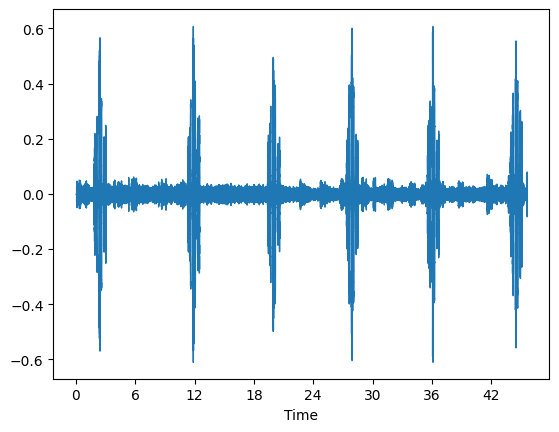

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [10]:
librosa.display.waveshow(audio_data,sr=sampling_rate)
ipd.Audio(filename=filename, rate=sampling_rate)

In [11]:
mfccs_features = librosa.feature.mfcc(y=audio_data, sr=sampling_rate, n_mfcc=40)
mfccs_features

array([[-4.7565851e+02, -3.3129114e+02, -2.9382373e+02, ...,
        -2.9407053e+02, -2.6429852e+02, -3.1357742e+02],
       [ 6.4723587e+01,  4.8800148e+01,  3.0958853e+01, ...,
         3.9688614e+01,  7.8858261e+01,  9.4898376e+01],
       [ 3.0281847e+01,  2.2574059e+01,  1.0889378e+01, ...,
         1.2291723e+01,  2.5062336e+01,  2.6268227e+01],
       ...,
       [-7.5498266e+00, -3.3256621e+00,  2.7236233e+00, ...,
         6.4915981e+00,  6.1443067e+00,  4.8556280e+00],
       [ 2.4894755e+00,  2.3624086e+00,  9.7443938e-01, ...,
         1.6173246e+00,  4.4563565e-01, -3.5551482e-01],
       [ 9.5930648e-01,  1.6378360e+00,  2.7122717e+00, ...,
         6.4043455e+00,  4.4303932e+00,  4.5397778e+00]], dtype=float32)

In [12]:
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
mfccs_scaled_features

array([-3.02472870e+02,  3.65253758e+00, -1.61132183e+01,  3.63370442e+00,
       -1.73015320e+00, -8.63115406e+00,  4.71711349e+00,  1.28732948e+01,
        1.03681316e+01,  2.14360886e+01,  1.31963758e+01,  8.50434685e+00,
        6.35560846e+00,  8.79970932e+00,  3.15153027e+00,  1.20604925e+01,
        9.66134548e+00,  8.08003330e+00, -3.31969678e-01,  5.35988212e-01,
       -2.05300808e+00,  4.92492342e+00,  4.48030949e+00,  6.66860294e+00,
        2.44400215e+00,  7.90587187e+00,  2.83253479e+00,  4.69282818e+00,
       -3.99052978e-01,  1.36950517e+00, -1.40676424e-01,  3.94826508e+00,
       -1.53376079e+00,  2.47172046e+00,  1.26603103e+00,  4.43730927e+00,
        1.57033479e+00,  5.55401802e+00,  2.23351336e+00,  4.87867451e+00],
      dtype=float32)

In [13]:
y = df['primary_label']
X = mfccs_scaled_features

In [33]:
def features_extractor(file):
    audio, sample_rate = librosa.load(file, res_type='kaiser_fast')
    # mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=20)
    # mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate,  n_mfcc=13, , )
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

    return mfccs_scaled_features

In [34]:
extracted_features_20=[]
extracted_features_labels_20=[]
for index_num,row in tqdm(df.iterrows()):
    file_name = os.path.join(DATASET_PATH, 'train_audio', row["filename"])
    final_class_labels=row["primary_label"]
    data=features_extractor(file_name)
    # extracted_features.append([data,final_class_labels])
    extracted_features_20.append(data)
    extracted_features_labels_20.append(final_class_labels)

16941it [1:05:51,  4.29it/s]


In [17]:
extracted_features

[array([-3.0934012e+02,  1.3472110e+01, -2.5858429e+01,  1.3250511e+01,
        -1.1159777e+01,  5.6030506e-01, -4.1883049e+00,  2.1445475e+01,
         2.1642187e+00,  2.9231251e+01,  5.8338165e+00,  1.5404541e+01,
        -6.7509912e-02,  1.4728385e+01, -2.2771351e+00,  1.6985365e+01,
         5.2395949e+00,  1.2007013e+01, -3.7718949e+00,  3.5065613e+00,
        -4.5681820e+00,  7.0073304e+00,  2.8095441e+00,  7.9526410e+00,
         1.5211445e+00,  8.4933586e+00,  2.5531776e+00,  4.6891651e+00,
        -1.4004324e-01,  8.7971771e-01,  5.5567110e-01,  3.0693882e+00,
        -4.9213612e-01,  1.2904025e+00,  2.5715528e+00,  3.0281386e+00,
         3.0703187e+00,  3.9798295e+00,  3.8707542e+00,  3.1901813e+00],
       dtype=float32),
 array([-3.2224191e+02, -6.5054832e+01, -1.4269893e+02, -3.4687199e+01,
        -4.3026398e+01,  7.6212120e-01,  2.0117943e+00,  2.7565800e+01,
         4.1739302e+00,  2.5533264e+01, -3.0644987e+00,  8.2968550e+00,
        -1.6130421e+01,  3.6911485e+00, 

In [35]:
# # save extracted_features using pickle
#
# with open('extracted_features_20.pkl', 'wb') as f:
#     pickle.dump(extracted_features_20, f)
# with open('extracted_features_labels_20.pkl', 'wb') as f:
#     pickle.dump(extracted_features_labels_20, f)

In [16]:
# # load extracted_features using pickle
#
# with open('extracted_features.pkl', 'rb') as f:
#     extracted_features = pickle.load(f)
# with open('extracted_features_labels.pkl', 'rb') as f:
#     extracted_features_labels = pickle.load(f)


In [44]:
X = extracted_features
y = extracted_features_labels
# X = extracted_features_20
# y = extracted_features_labels_20

In [45]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
y_transformed = labelencoder.fit_transform(y)

In [46]:
# covert list of ndarrays to higher dimention ndarray

X = np.array(X)

In [47]:
X.shape

(16941, 40)

In [48]:
df.shape

(16941, 12)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size=0.1, random_state=42)


In [50]:
cls = MLPClassifier()
# fitted_cls = cls.fit(X_train, y_train)
# y_pred = fitted_cls.predict(X_test)
# accuracy_score(y_test, y_pred)

In [56]:
from catboost import CatBoostClassifier

classifiers = {
    # "SVC(kernel=\"linear\", C=0.025)": SVC(kernel="linear", C=0.025),
    # "SVC(gamma=2, C=1)": SVC(gamma=2, C=1),
    "SVC": SVC(),
    "MLPClassifier": MLPClassifier(hidden_layer_sizes=(100, 200, 100), max_iter=500),
    # "RidgeClassifier": RidgeClassifier(),
    "k-Nearest Neighbors": KNeighborsClassifier(2),  # TMP comment
    "Decision Tree": DecisionTreeClassifier(), # not bas results
    "AdaBoostClassifier(),": AdaBoostClassifier(),
    # "AdaBoostClassifier_DecTree": AdaBoostClassifier(DecisionTreeClassifier(),learning_rate=1),  # TMP comment
    # "RandomForestClassifier": RandomForestClassifier(max_depth = m_depth),
    "RandomForestClassifier": RandomForestClassifier(),
    # "AdaBoostClassifierRndForrest": AdaBoostClassifier(RandomForestClassifier(),learning_rate=1),
    # "CatBoostClassifier": CatBoostClassifier(max_depth = m_depth, silent = True),
    "CatBoostClassifier": CatBoostClassifier(silent = True),
    # "LGBMClassifier": LGBMClassifier(max_depth = m_depth),
    # "LGBMClassifier": LGBMClassifier(),  # TODO try
    # "XGBClassifier": XGBClassifier(max_depth = m_depth, use_label_encoder=False),
    # "XGBClassifier": XGBClassifier(use_label_encoder=False), # not bas results  # feature names must be unique, # TODO fix
}
trained_classifiers = {}

for cls_name, cls in classifiers.items():
    print(f"=== {cls_name} ===")
    fitted_cls = cls.fit(X_train, y_train)
    trained_classifiers[cls_name] = fitted_cls
    y_pred = fitted_cls.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    # plot_confusion_matrix(cnf_matrix, classes=[0,1], title='Confusion matrix, original data')
    print('\nOriginal data \nAccuracy: ', accuracy, '  Precision: ', precision)

=== SVC ===


/Users/jakubkucera/Documents/quantum_stuff/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Original data 
Accuracy:  0.11327433628318584   Precision:  0.02416477637598156
=== MLPClassifier ===


/Users/jakubkucera/Documents/quantum_stuff/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jakubkucera/Documents/quantum_stuff/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Original data 
Accuracy:  0.18761061946902655   Precision:  0.10563692121558163
=== k-Nearest Neighbors ===

Original data 
Accuracy:  0.12389380530973451   Precision:  0.08390751359650232
=== Decision Tree ===


/Users/jakubkucera/Documents/quantum_stuff/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Original data 
Accuracy:  0.0943952802359882   Precision:  0.0457800064250128
=== AdaBoostClassifier(), ===


/Users/jakubkucera/Documents/quantum_stuff/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Original data 
Accuracy:  0.04129793510324484   Precision:  0.002012096903444825
=== RandomForestClassifier ===


/Users/jakubkucera/Documents/quantum_stuff/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Original data 
Accuracy:  0.24424778761061947   Precision:  0.19810777143312563
=== CatBoostClassifier ===

Original data 
Accuracy:  0.2837758112094395   Precision:  0.1968245025980014


/Users/jakubkucera/Documents/quantum_stuff/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
mlp_param_grid = {
    'hidden_layer_sizes': [(25, ), (50, ), (100, ), (200,), (25, 25), (50, 50), (100, 100), (200, 200), (200, 100, 200), (150,100,50), (120,80,40), (100,50,30), (1024, 512, 256, 128, 64, 32, 16, 8, 4)],
    'max_iter': [500],
# 'max_iter': [50, 100, 150],
# 'activation': ['tanh', 'relu'],
# 'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
# 'learning_rate': ['constant','adaptive'],
    'learning_rate_init': [0.0001, 0.0005, 0.001, 0.01],
    }

trained_classifiers_mlp = {}

for params in ParameterGrid(mlp_param_grid):
    print(f"=== {params} ===")
    cls = MLPClassifier(**params)
    fitted_cls = cls.fit(X_train, y_train)
    trained_classifiers_mlp[str(params)] = fitted_cls
    y_pred = fitted_cls.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    # plot_confusion_matrix(cnf_matrix, classes=[0,1], title='Confusion matrix, original data')
    print('\nOriginal data \nAccuracy: ', accuracy)

=== {'alpha': 0.0001, 'hidden_layer_sizes': (25,), 'learning_rate_init': 0.0001, 'max_iter': 500} ===


/Users/jakubkucera/Documents/quantum_stuff/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



Original data 
Accuracy:  0.17935103244837758
=== {'alpha': 0.0001, 'hidden_layer_sizes': (25,), 'learning_rate_init': 0.0005, 'max_iter': 500} ===

Original data 
Accuracy:  0.19823008849557522
=== {'alpha': 0.0001, 'hidden_layer_sizes': (25,), 'learning_rate_init': 0.001, 'max_iter': 500} ===

Original data 
Accuracy:  0.20707964601769913
=== {'alpha': 0.0001, 'hidden_layer_sizes': (25,), 'learning_rate_init': 0.01, 'max_iter': 500} ===

Original data 
Accuracy:  0.1410029498525074
=== {'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.0001, 'max_iter': 500} ===


/Users/jakubkucera/Documents/quantum_stuff/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



Original data 
Accuracy:  0.1952802359882006
=== {'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.0005, 'max_iter': 500} ===


/Users/jakubkucera/Documents/quantum_stuff/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



Original data 
Accuracy:  0.215929203539823
=== {'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.001, 'max_iter': 500} ===

Original data 
Accuracy:  0.20707964601769913
=== {'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.01, 'max_iter': 500} ===

Original data 
Accuracy:  0.1592920353982301
=== {'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.0001, 'max_iter': 500} ===


/Users/jakubkucera/Documents/quantum_stuff/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



Original data 
Accuracy:  0.22536873156342183
=== {'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.0005, 'max_iter': 500} ===


/Users/jakubkucera/Documents/quantum_stuff/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



Original data 
Accuracy:  0.22064896755162242
=== {'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001, 'max_iter': 500} ===

Original data 
Accuracy:  0.215929203539823
=== {'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.01, 'max_iter': 500} ===

Original data 
Accuracy:  0.1687315634218289
=== {'alpha': 0.0001, 'hidden_layer_sizes': (200,), 'learning_rate_init': 0.0001, 'max_iter': 500} ===


/Users/jakubkucera/Documents/quantum_stuff/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



Original data 
Accuracy:  0.21946902654867256
=== {'alpha': 0.0001, 'hidden_layer_sizes': (200,), 'learning_rate_init': 0.0005, 'max_iter': 500} ===


/Users/jakubkucera/Documents/quantum_stuff/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



Original data 
Accuracy:  0.22359882005899706
=== {'alpha': 0.0001, 'hidden_layer_sizes': (200,), 'learning_rate_init': 0.001, 'max_iter': 500} ===

Original data 
Accuracy:  0.21002949852507374
=== {'alpha': 0.0001, 'hidden_layer_sizes': (200,), 'learning_rate_init': 0.01, 'max_iter': 500} ===

Original data 
Accuracy:  0.12861356932153392
=== {'alpha': 0.0001, 'hidden_layer_sizes': (25, 25), 'learning_rate_init': 0.0001, 'max_iter': 500} ===


/Users/jakubkucera/Documents/quantum_stuff/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



Original data 
Accuracy:  0.17699115044247787
=== {'alpha': 0.0001, 'hidden_layer_sizes': (25, 25), 'learning_rate_init': 0.0005, 'max_iter': 500} ===


/Users/jakubkucera/Documents/quantum_stuff/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



Original data 
Accuracy:  0.2
=== {'alpha': 0.0001, 'hidden_layer_sizes': (25, 25), 'learning_rate_init': 0.001, 'max_iter': 500} ===

Original data 
Accuracy:  0.19469026548672566
=== {'alpha': 0.0001, 'hidden_layer_sizes': (25, 25), 'learning_rate_init': 0.01, 'max_iter': 500} ===

Original data 
Accuracy:  0.1486725663716814
=== {'alpha': 0.0001, 'hidden_layer_sizes': (50, 50), 'learning_rate_init': 0.0001, 'max_iter': 500} ===


/Users/jakubkucera/Documents/quantum_stuff/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



Original data 
Accuracy:  0.20943952802359883
=== {'alpha': 0.0001, 'hidden_layer_sizes': (50, 50), 'learning_rate_init': 0.0005, 'max_iter': 500} ===


/Users/jakubkucera/Documents/quantum_stuff/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



Original data 
Accuracy:  0.21179941002949854
=== {'alpha': 0.0001, 'hidden_layer_sizes': (50, 50), 'learning_rate_init': 0.001, 'max_iter': 500} ===

Original data 
Accuracy:  0.21474926253687315
=== {'alpha': 0.0001, 'hidden_layer_sizes': (50, 50), 'learning_rate_init': 0.01, 'max_iter': 500} ===

Original data 
Accuracy:  0.15339233038348082
=== {'alpha': 0.0001, 'hidden_layer_sizes': (100, 100), 'learning_rate_init': 0.0001, 'max_iter': 500} ===


/Users/jakubkucera/Documents/quantum_stuff/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



Original data 
Accuracy:  0.2377581120943953
=== {'alpha': 0.0001, 'hidden_layer_sizes': (100, 100), 'learning_rate_init': 0.0005, 'max_iter': 500} ===


/Users/jakubkucera/Documents/quantum_stuff/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



Original data 
Accuracy:  0.18289085545722714
=== {'alpha': 0.0001, 'hidden_layer_sizes': (100, 100), 'learning_rate_init': 0.001, 'max_iter': 500} ===

Original data 
Accuracy:  0.1976401179941003
=== {'alpha': 0.0001, 'hidden_layer_sizes': (100, 100), 'learning_rate_init': 0.01, 'max_iter': 500} ===

Original data 
Accuracy:  0.16283185840707964
=== {'alpha': 0.0001, 'hidden_layer_sizes': (200, 200), 'learning_rate_init': 0.0001, 'max_iter': 500} ===


/Users/jakubkucera/Documents/quantum_stuff/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



Original data 
Accuracy:  0.2424778761061947
=== {'alpha': 0.0001, 'hidden_layer_sizes': (200, 200), 'learning_rate_init': 0.0005, 'max_iter': 500} ===

Original data 
Accuracy:  0.19882005899705016
=== {'alpha': 0.0001, 'hidden_layer_sizes': (200, 200), 'learning_rate_init': 0.001, 'max_iter': 500} ===

Original data 
Accuracy:  0.20117994100294986
=== {'alpha': 0.0001, 'hidden_layer_sizes': (200, 200), 'learning_rate_init': 0.01, 'max_iter': 500} ===

Original data 
Accuracy:  0.16283185840707964
=== {'alpha': 0.0001, 'hidden_layer_sizes': (200, 100, 200), 'learning_rate_init': 0.0001, 'max_iter': 500} ===


/Users/jakubkucera/Documents/quantum_stuff/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



Original data 
Accuracy:  0.22536873156342183
=== {'alpha': 0.0001, 'hidden_layer_sizes': (200, 100, 200), 'learning_rate_init': 0.0005, 'max_iter': 500} ===

Original data 
Accuracy:  0.21710914454277286
=== {'alpha': 0.0001, 'hidden_layer_sizes': (200, 100, 200), 'learning_rate_init': 0.001, 'max_iter': 500} ===

Original data 
Accuracy:  0.2182890855457227
=== {'alpha': 0.0001, 'hidden_layer_sizes': (200, 100, 200), 'learning_rate_init': 0.01, 'max_iter': 500} ===

Original data 
Accuracy:  0.0920353982300885
=== {'alpha': 0.0001, 'hidden_layer_sizes': (150, 100, 50), 'learning_rate_init': 0.0001, 'max_iter': 500} ===


/Users/jakubkucera/Documents/quantum_stuff/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



Original data 
Accuracy:  0.2182890855457227
=== {'alpha': 0.0001, 'hidden_layer_sizes': (150, 100, 50), 'learning_rate_init': 0.0005, 'max_iter': 500} ===


/Users/jakubkucera/Documents/quantum_stuff/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



Original data 
Accuracy:  0.1752212389380531
=== {'alpha': 0.0001, 'hidden_layer_sizes': (150, 100, 50), 'learning_rate_init': 0.001, 'max_iter': 500} ===

Original data 
Accuracy:  0.1911504424778761
=== {'alpha': 0.0001, 'hidden_layer_sizes': (150, 100, 50), 'learning_rate_init': 0.01, 'max_iter': 500} ===

Original data 
Accuracy:  0.024188790560471976
=== {'alpha': 0.0001, 'hidden_layer_sizes': (120, 80, 40), 'learning_rate_init': 0.0001, 'max_iter': 500} ===


/Users/jakubkucera/Documents/quantum_stuff/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



Original data 
Accuracy:  0.2112094395280236
=== {'alpha': 0.0001, 'hidden_layer_sizes': (120, 80, 40), 'learning_rate_init': 0.0005, 'max_iter': 500} ===


/Users/jakubkucera/Documents/quantum_stuff/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



Original data 
Accuracy:  0.20058997050147492
=== {'alpha': 0.0001, 'hidden_layer_sizes': (120, 80, 40), 'learning_rate_init': 0.001, 'max_iter': 500} ===

Original data 
Accuracy:  0.1864306784660767
=== {'alpha': 0.0001, 'hidden_layer_sizes': (120, 80, 40), 'learning_rate_init': 0.01, 'max_iter': 500} ===

Original data 
Accuracy:  0.1368731563421829
=== {'alpha': 0.0001, 'hidden_layer_sizes': (100, 50, 30), 'learning_rate_init': 0.0001, 'max_iter': 500} ===


/Users/jakubkucera/Documents/quantum_stuff/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



Original data 
Accuracy:  0.19705014749262537
=== {'alpha': 0.0001, 'hidden_layer_sizes': (100, 50, 30), 'learning_rate_init': 0.0005, 'max_iter': 500} ===

Original data 
Accuracy:  0.1929203539823009
=== {'alpha': 0.0001, 'hidden_layer_sizes': (100, 50, 30), 'learning_rate_init': 0.001, 'max_iter': 500} ===

Original data 
Accuracy:  0.18584070796460178
=== {'alpha': 0.0001, 'hidden_layer_sizes': (100, 50, 30), 'learning_rate_init': 0.01, 'max_iter': 500} ===

Original data 
Accuracy:  0.15457227138643068
=== {'alpha': 0.0001, 'hidden_layer_sizes': (1024, 512, 256, 128, 64, 32, 16, 8, 4), 'learning_rate_init': 0.0001, 'max_iter': 500} ===
